# **TPE 1: Métodos de Búsqueda**

## **Datos del trabajo** 

### Alumnos: 
- Apablaza, Matías (59714)
- Beade, Gonzalo (61223)
- D'Agostino, Leonardo Agustín (60335)


### Docentes:
- Rodrigo Ramele
- Juliana Gambini 
- Juan Santos 
- Paula Oseroff
- Eugenia Piñeiro
- Santiago Reyes


### Fecha:
- Primer Cuatrimestre 2022

## **Introducción** 

En el siguiente trabajo práctico implementamos estrategias de búsqueda 
(tanto informadas como no informadas) y las comparamos según su desempeño a la hora de resolver de un desafío. El desarrollo del trabajo gira en torno a la resolución del **Juego de los 8 números** (de ahora en más, \' el Juego\') , cuyas reglas se describen a continuación. 


## Reglas del Juego: 
Dada una tabla de 3x3 rellena con casillas numéricas del 1 al 8 y una casilla vacía o blanca, distribuidas de manera azarosa, el Juego termina al ordenar de menor a mayor los contenidos del cuadrado, siendo la casilla blanca la cola de la sucesión. 

Los únicos movimientos permitidos son aquellos que permutan la casilla vacía con una casilla númerica inmediata, en sentido vertical u horizontal. 


## Estado del Juego: 

Decimos que una disposición de casillas dentro de la tabla de 3x3 representa un estado del Juego. Al permutar la casilla blanca con otra, se induce un nuevo estado en el Juego.

## **Desarrollo** 

Si se va a ejecutar código desde el notebook, correr todos los módulos en el orden en el que lo exponemos. 

### **Importación de librerías a utilizar**

Para este trabajo, vamos a utilizar las librerías:

1.   `matplotlib` para hacer análisis de datos. 
2.   `numpy` para hacer algunas conversiones matemáticas eficientemente. 
3.   `heapq` porque Python no tiene implementación nativa de la estructura de datos heap. 
4.   `graphviz` para producir árboles de estados



In [ ]:
from matplotlib import pyplot as plt 
import numpy as np
import copy
from heapq import *
import graphviz

### **Implementación de la API del Juego**


Empezamos creando una interfaz que represente el estado de un juego cualquier, llamada GameState en nuestra implementación. 

La interfaz se desprende de la tarea en inteligencia artificial y provee métodos que permitirían jugar a cualquier juego de un solo jugador en general. 

In [ ]:
class GameState():

  """ Devuelve verdadero si el estado es objetivo/ganador"""
  @property
  def isobjective(self):
    raise Exception('Not implemented exception')

  """
  Devuelve un conjunto de strings representando movimientos posibles
  según las reglas del juego
  """
  @property
  def game_moves(self):
    raise Exception('Not implemented exception')

  """
  Ejecuta un movimiento en el juego. De ser válido, devuelve un nuevo estado con dicho movimiento ejecutado
  """
  def make_move(self, m: str):
    raise Exception('Not implemented exception')

  """
  Todo juego debe poder mostrarse en pantalla, aunque sea una representación muy básica
  """
  def __str__(self): 
    return 'Empty Game!'

  """
  Todo juego debe poder devolver un conjunto de pares con informacion del estado interno del mismo
  """
  @property
  def data(self): 
    raise Exception('Not implemented exception')

Cualquier implementación de esta interfaz debe implementar la igualdad y una apropiada función de hash porque el algoritmo de resolución de búsquedas trabaja con conjuntos. La implementación de set en `Python` es con tablas de hashing. 

A continuación exponemos una de las implementaciones posibles para realizar este trabajo, para el Juego de los 8 Números. 


In [ ]:
class EightGameState(GameState):

  offsets = {'f':-3 , 'b':3 , 'l':-1 , 'r':1}
  goal_table = [1, 2, 3, 4, 5, 6, 7, 8, 0]

  def __init__(self, **kwargs):
    self.table = kwargs.get('table', EightGameState.__new_table()) # TODO: deberia ser una tupla
    self.zero = kwargs.get('target', self.table.index(0))
    self.__swap(self, self.zero, kwargs.get('source', self.zero)) 

  @staticmethod
  def __new_table():
    x = np.arange(9)
    np.random.shuffle(x)
    return x.tolist()  

  @staticmethod 
  def __swap(self, n, z):
      self.table[n], self.table[z] = self.table[z], self.table[n]

  @staticmethod
  def setGoalTable(table):
    EightGameState.goal_table = table

  @property 
  def matrix(self): 
    return np.reshape(self.table, (3, 3))

  @property
  def isobjective(self):
    return self.table == [1, 2, 3, 4, 5, 6, 7, 8, 0]# EightGameState.goal_table

  def make_move(self, m: str):
    if m not in self.offsets.keys():
      raise 'Invalid move code'

    if (m == 'f' and self.zero < 3) \
      or (m == 'b' and self.zero >= 6) \
      or (m == 'l' and self.zero % 3 == 0 ) \
      or (m == 'r' and self.zero % 3 == 2 ):  
        return None   
    
    new_zero = self.zero + self.offsets[m]
    return EightGameState(table=copy.deepcopy(self.table), source=self.zero, target=new_zero)

  def __hash__(self): 
    return hash(tuple(self.table))

  def __eq__(self, o): 
    return isinstance(o, EightGameState) and o.table == self.table

  @property
  def game_moves(self):
    return {'b': 1, 'f': 1, 'l': 1, 'r': 1}

  def __str__(self): 
    return str(np.reshape(self.table, (3, 3)))

  @property
  def data(self):
    d = {} 
    for pos in range(9): 
      d[str(pos+1)] = self.table[pos]
    return d

### **Diseño de clases para el agente buscador de soluciones**

Empezamos implementando una clase `Node`. Ésta nos permite hacer crecer un árbol de rótulos de estados a medida que lo necesitemos. Los estamos haciendo genéricos para todos los tipos de búsqueda, pero podríamos hacer que cada tipo de búsqueda tenga su propio tipo de `Node` según corresponda. 

In [ ]:
class Node:

    LAST_ID = 0
    LAST_EXPLORED_ORDER = 0

    def __init__(self, game_state: GameState, parent, depth, cost, src_action):
        self.game_state = game_state
        self.children = [] 
        self.parent = parent
        self.depth = depth
        self.cost = cost
        self.id = Node.LAST_ID
        self.explore_order = -1
        self.src_action = src_action
        Node.LAST_ID += 1

    def add(self, node):
      self.children.append(node)

    def mark_explored(self):
      self.explore_order = Node.LAST_EXPLORED_ORDER
      Node.LAST_EXPLORED_ORDER += 1

    @property
    def state(self): 
      return self.game_state

    def __hash__(self): 
      return hash(self.game_state)

    def __eq__(self, other):
      return type(other) is Node and self.game_state == other.game_state

La implementación de los métodos de búsqueda consiste en una clase resolvedora abstracta `Solver`, que implementa un método genérico, ni informado ni no informado. 

Las clases que heredan de `Solver` implementan los distintos algoritmos vistos en clase. Esta implementación muestra que es una familia de algoritmos. Solo cambia la elección del próximo estado a elegir a partir del estado actual en el árbol de estados. 

In [ ]:
class Solver():

    '''
      La funcion score es una funcion que 
      - dado un nodo representante de un estado del juego -
      permite  saber su puntaje. Mientras menor sea el puntaje, mejor. 
      El algoritmo selecciona al que menor valor de score tiene. 
      Si se quiere seleccionar al que mayor valor de score tenga, se lo puede multiplicar por -1
    '''
    def score(self, node): 
      raise 'Not implemented exception'

    def __init__(self, game_state: GameState):
      self.initial_state = game_state
      self.root = self.new_node(self.initial_state, None, 0, 0, '') 

    @property 
    def initial_node(self): 
      return self.root

    
    def __iter__(self):
      # self.iter_done = False 
      self.frontier = [] # La Frontera es un Heap (AKA Priority Queue). No tiene sentido agregar y ordenar a futuro, mantenelo ordenado
      self.explored = set() 
      heappush(self.frontier, (self.score(self.root), 0, self.root))
      return self

    ''' 
      En cada iteracion devuelve 
        Excepcion si no pudo encontrar solucion
        Un Nodo valido si encontro solucion
        None si sigue buscando 
      El iterador no se destruye al encontrar una solucion, va a seguir buscando y la hoja solucion muere ahi    
    '''
    def __next__(self):

      self.check_frontier()
      n = heappop(self.frontier)[-1]
      self.mark_explored(n)

      if n.state.isobjective: 
        return n, True  
      
      game_moves = n.game_state.game_moves
      for m in game_moves.keys(): 
        new_state = n.game_state.make_move(m)
        if new_state is not None:
          node = self.new_node(new_state, n, n.depth + 1, n.cost + game_moves[m], m)
          if self.should_explore(node):
            n.add(node) 
            self.push_to_heap(node)
    
      return n, False

    def should_explore(self, node): 
      return node.game_state not in self.explored

    def new_node(self, new_state, parent, depth, cost, src_action):
      return Node(new_state, parent, parent.depth+1 if parent != None else 0, cost, src_action)

    def check_frontier(self):
      if len(self.frontier) == 0:  # TODO: aca podriamos aplicar lo de la profundidad en una extension del metodo
        raise StopIteration 
    
    def push_to_heap(self, node):
        heappush(self.frontier, (self.score(node), node.id, node)) # Le agrego el ID para romper desempates  # me esta siempre pusheando al heap 

    def mark_explored(self, n):
       n.mark_explored()
       self.explored.add(n.game_state) # como es un set, no pasa nada si ya estaba


In [ ]:
class SolverBPA(Solver): 
  def score(self, node): 
    return node.depth

In [ ]:
class SolverBPP(Solver):  
  def score(self, node): 
    return -node.depth

In [ ]:
class SolverBPPV(SolverBPP):
  # Considerar que pueden haber estados repetidos a distinta profundidad

  def __init__(self, game_state: GameState, start_limit: int):
    super().__init__(game_state)
    self.max_depth = start_limit

  def mark_explored(self, n):
    n.mark_explored()
    self.explored[n.game_state] = min(self.explored.get(n.game_state, n.depth), n.depth)

  def __iter__(self):
    x =  super().__iter__()
    self.explored = {}
    return x

  def should_explore(self, node):
    return node.game_state not in self.explored.keys() or self.explored[node.game_state] > node.depth

  def push_to_heap(self, node):
    heappush(self.frontier, ( int(node.depth / (self.max_depth + 1)), self.score(node), node.id, node)) # Le agrego el ID para romper desempates  # me esta siempre pusheando al heapeando al heap 


In [ ]:
class SolverHeuristic(Solver): 
  
  def __init__(self, game_state: GameState, heuristic):
    self.h = heuristic
    super().__init__(game_state)

  def score(self, node): 
    return node.heuristic

  def new_node(self, new_state, parent, depth, cost, src_action):
    n = self.HeuristicNode(new_state, parent, parent.depth+1 if parent != None else 0, cost, src_action, self.h(new_state))
    return n

  class HeuristicNode(Node):

    def __init__(self, state, n, depth, cost, src_action, heuristic):
      super().__init__(state, n, depth, cost, src_action)
      self.heuristic = heuristic

In [ ]:
class SolverLocalHeuristic(SolverHeuristic):

  def __init__(self, game_state: GameState, heuristic):
    super().__init__(game_state, heuristic)

  def push_to_heap(self, node):
    heappush(self.frontier, ( -node.depth, self.score(node), node.id, node))

In [ ]:
class SolverGlobalHeuristic(SolverHeuristic):

  def __init__(self, game_state: GameState, heuristic):
    super().__init__(game_state, heuristic)
  
  def push_to_heap(self, node):
    heappush(self.frontier, (self.score(node), node.id, node))

In [ ]:
class SolverWeightHeuristic(SolverHeuristic):
  
  def __init__(self, game_state: GameState, heuristic, w):
    super().__init__(game_state, heuristic)
    self.w = w

  def score(self, node): 
    return node.heuristic * self.w + node.cost * (1-self.w)
    
  def push_to_heap(self, node):
    heappush(self.frontier, (self.score(node), node.id, node))

Como la clase de algoritmos informados recibe una heurística de manera arbitraria, tenemos que definir esas heurísticas por fuera, para poder pasárselas como parámetro. Exponemos a continuación las heurísticas que vamos a usar para resolver al Juego, y un análisis sobre su admisibilidad. 

`correctnes_heuristic` cuenta casillero a casillero si el número que allí reside está bien posicionado o no. El casillero blanco no se cuenta para facilitar las demostraciones. A continuación enunciamos propiedades de está heurística. 

1. `correctnes_heuristic(state) == 0` sii todos los números están en su lugar. La demostración es por el absurdo. Supongamos que devuelve 0 y hay al menos un número mal ubicado. Entonces, por definición, está ocupando el casillero de otro número y la heurística devolvería un valor mayor a uno.

2. `correctnes_heuristic` es admisible pues nunca sobre-estima el costo de llegar a una solución. Es decir, para todo estado `state`, `correctnes_heuristic(state) <= h_star(state)`.  La demostración es por el absurdo. Supongamos que `correctnes_heuristic` sobre-estime el costo de llegar a una solución, es decir que haya n+1 números mal puestos que puede resolverse en n movimientos (1<=n<8). La única manera que tendría el 0 de recorrer esta problemática es no volver a un lugar en el que ya estuvo. Como el 0 nunca pasa por un lugar en el que ya estuvo, tiene que inducir n+1 swaps para corregir las posiciones de los n+1 números incorrectamente posicionados en n movimientos. Absurdo. 
 


In [ ]:
def correctnes_heuristic(state): 
  table = state.data
  count = 0

  for position in table.keys():
    number = table[position]
    count += 1 if number != 0 and int(position) != number else 0

  return count

`manhattan_heuristic` es la suma de las distancias en norma 1 entre la posición real de cada número y la posición esperada de cada número. A continuación enunciamos propiedades de esta heurística.

1. `manhattan_heuristic(state) == 0` sii todos los números están en su lugar. La demostración es directa. Como es una suma en los naturales, solo puede ser nula sii todo sumando es nulo. Si todo sumando es nulo, entonces la diferencia entre las posicones ideales y reales de cada número es nula. Es decir, están bien posicionados. 

2. `manhattan_heuristic` es admisible. La demostración es directa. Un número mal puesto N tiene que recorrer como mínimo la distancia manhattan al lugar donde corresponde. Sin embargo, el 0 es la única casilla que puede inducir un movimiento en el número. Si el 0 induce un movimiento dos veces consecutivas en el mismo número, entonces vuelve al estado original. Por eso, el 0 tendrá que inducir un movimiento en algún otro número antes de volver a mover a N, probando que el costo real es siempre mayor al estimado por la heurística. 

In [ ]:
def manhattan_heuristic(state): 
  table = state.data
  distance_sum = 0

  for position in table.keys():
    number = table[position]
    if number == 0:
      continue

    x1 = (int(position)-1) % 3
    y1 = int((int(position)) / 3)

    x2 = (number-1) % 3
    y2 = int((number-1) / 3)
    
    distance_sum += abs(x2-x1) + abs(y2-y1)
  
  return distance_sum

Por último, presentamos `manhattan_squared_heuristic`, definida igual que `manhattan_heuristic`, mas sumamos los cuadrados de las distancias en vez de sus distancias lineales. La idea es penalizar severamente a los estado que tienen a muy mal puestos a sus números, y no tanto a los que tienen a sus casilleros bien puestos. Algunas propiedades de esta heurística son: 

1. `manhattan_squared_heuristic(state) == 0` sii todos los números están en su lugar. La demostración es análoga a la de `manhattan_heuristic`, pero factorizando el cuadrado de cada término en el paso final y llegando a la misma conclusión. 

2. `manhattan_squared_heuristic` no es admisible. El contraejemplo que se muestra  tiene valor de heurística 8, pero puede resolverse en 7 movimientos.

1 2 3

5 6 8 

4 0 7


In [ ]:
def manhattan_heuristic(state): 
  table = state.data
  distance_sum = 0

  for position in table.keys():
    number = table[position]
    if number == 0:
      continue

    x1 = (int(position)-1) % 3
    y1 = int((int(position)) / 3)

    x2 = (number-1) % 3
    y2 = int((number-1) / 3)
    
    distance_sum += (abs(x2-x1) + abs(y2-y1))**2
  
  return distance_sum

In [ ]:
# # Este es un ejemplo sencillo que tiene enrocados los ultimos 4 valores 
# # En un par de pasos lo encuentra 
# gs = EightGameState(table=[8, 1, 2, 3, 4, 0, 7, 6, 5], target=5, source=5) 

# solver = SolverGlobalHeuristic(gs, correctnes_heuristic)
# iterator = iter(solver)

# solved = False
# n = None
# while not solved:
# # for i in range(100):
#   n, solved = next(iterator)
#   #print(n.game_state)
#   #i += 1

# print(n.game_state.matrix)
# print(n.game_state.isobjective)

### **Clases para visualización del árbol de estados**

In [ ]:
def node_label(node): 
  string = f"Ord: {node.explore_order}\n"
  string += f"Cost: {node.cost}\n"
  if type(node) is SolverHeuristic.HeuristicNode:
    string += f"Heu: {node.heuristic}\n"
    # string += f"A*: {node.cost*0.5 + node.heuristic*0.5}\n"
  string += f"\n{node.game_state}"
  return string

def build_graphviz_tree(node, graph):
    color = 'green' if node.game_state.isobjective else 'white' 
    graph.node(str(node.id), node_label(node), style='filled', fillcolor=color)

    for child in node.children:
        build_graphviz_tree(child, graph)
        graph.edge(str(node.id), str(child.id), label=child.src_action)

def build_graphviz_branch(node, graph):
    color = 'green' if node.game_state.isobjective else 'white' 
    graph.node(str(node.id), node_label(node), style='filled', fillcolor=color)

    if node.parent != None:
        build_graphviz_branch(node.parent, graph)
        graph.edge(str(node.parent.id), str(node.id), label=node.src_action)

def renderTree(root):
    graph = graphviz.Digraph('decision_tree')
    build_graphviz_tree(root, graph)
    graph.render(directory='out')

def renderBranch(leaf):
    graph = graphviz.Digraph('solution_branch')
    build_graphviz_branch(leaf, graph)
    graph.render(directory='out')

def get_solution_sequence(node):
  sequence = [{'move': node.src_action, 'state': node.state.data}]

  if node.parent != None:
    sequence += get_solution_sequence(node.parent)

  return sequence

In [ ]:
# renderBranch(n)
# renderTree(solver.initial_node)

### **Ejecución y comparación de los métodos de búsqueda**


En esta sección, correremos cada algoritmo en 1000 tableros de prueba generados de manera aleatoria. 

Para cada matriz generada, medimos el tiempo de ejecución empírico que costó llegar a la solución. 

In [ ]:
results = {
   'bpp': [19.77799701690674, 16.255499839782715, 14.029824256896973, 6.161742448806763, 19.626841068267822, 14.691667556762695, 16.2345290184021, 20.703670978546143, 21.046470165252686, 0.7022154331207275, 24.268346309661865, 19.954115629196167, 18.33606481552124, 0.7733786106109619, 17.154624938964844, 16.62529444694519, 16.578765630722046, 24.280343294143677, 18.78624725341797, 13.350395679473877, 19.8753445148468, 20.65025234222412, 24.220179796218872, 16.033488035202026], 
   'bpa': [3.312563180923462, 16.78014373779297, 1.5005578994750977, 24.11879277229309, 1.8123650550842285, 5.810397386550903, 40.823097467422485, 6.816702604293823, 6.657406330108643, 18.61001443862915, 17.433996200561523, 7.70969295501709, 18.402751445770264, 28.429038286209106, 43.07273745536804, 20.107848405838013, 4.085693359375, 44.44852304458618, 18.06688928604126, 51.225008964538574, 5.775974273681641, 45.00810360908508, 12.94466233253479, 19.502450466156006], 
   'bppv': [0.6835105419158936, 10.919771194458008, 3.3716070652008057, 5.283772706985474, 2.5469970703125, 7.605975389480591, 22.08494520187378, 2.589653730392456, 9.465485095977783, 9.367303609848022, 14.493930578231812, 4.114590644836426, 8.236675500869751, 17.15525984764099, 29.845795154571533, 17.496699571609497, 7.1406569480896, 26.032934427261353, 17.695763111114502, 22.35516858100891, 3.045971393585205, 29.264267683029175, 11.909547328948975, 16.876437187194824]
}

def solve(solver: Solver):
  iterator = iter(solver) 
  solved = False
  n = None
  first = next(iterator)
  while not solved:
    n, solved = next(iterator)



In [ ]:
import time 

for i in range(12): 
  print("TESTIN ITERATION #"+str(i)+'\n')
  state = EightGameState()

  start_time = 0
  end_time = 0 

  has_solution = True
  try: 
    start_time = time.time() 
    solve(SolverBPPV(state, 5))
    end_time = time.time() 
  except: 
    has_solution = False 
  
  if has_solution:
    results["bppv"].append(end_time - start_time)

    start_time = time.time() 
    solve(SolverBPP(state))
    end_time = time.time() 
    results["bpp"].append(end_time - start_time)

    start_time = time.time() 
    solve(SolverBPA(state))
    end_time = time.time() 
    results["bpa"].append(end_time - start_time)
  
  print("IGNORED? ", not has_solution)










TESTIN ITERATION #0

IGNORED?  False
TESTIN ITERATION #1

IGNORED?  True
TESTIN ITERATION #2

IGNORED?  True
TESTIN ITERATION #3

IGNORED?  False
TESTIN ITERATION #4

IGNORED?  True
TESTIN ITERATION #5

IGNORED?  False
TESTIN ITERATION #6

IGNORED?  True
TESTIN ITERATION #7

IGNORED?  False
TESTIN ITERATION #8

IGNORED?  True
TESTIN ITERATION #9

IGNORED?  True
TESTIN ITERATION #10

IGNORED?  False
TESTIN ITERATION #11

IGNORED?  False


In [ ]:
print(results)

{'bpp': [19.77799701690674, 16.255499839782715, 14.029824256896973, 6.161742448806763, 19.626841068267822, 14.691667556762695, 16.2345290184021, 20.703670978546143, 21.046470165252686, 0.7022154331207275, 24.268346309661865, 19.954115629196167, 18.33606481552124, 0.7733786106109619, 17.154624938964844, 16.62529444694519, 16.578765630722046, 24.280343294143677, 18.78624725341797, 13.350395679473877, 19.8753445148468, 20.65025234222412, 24.220179796218872, 16.033488035202026, 22.61146330833435, 17.84452509880066, 2.8655102252960205, 15.64052963256836, 16.278109073638916, 14.269929885864258], 'bpa': [3.312563180923462, 16.78014373779297, 1.5005578994750977, 24.11879277229309, 1.8123650550842285, 5.810397386550903, 40.823097467422485, 6.816702604293823, 6.657406330108643, 18.61001443862915, 17.433996200561523, 7.70969295501709, 18.402751445770264, 28.429038286209106, 43.07273745536804, 20.107848405838013, 4.085693359375, 44.44852304458618, 18.06688928604126, 51.225008964538574, 5.775974273

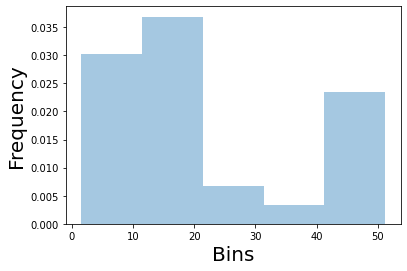

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.hist(np.array(results['bppv']), weights=np.zeros_like(np.array(results['bppv']))+1./ np.array(results['bppv']).size, bins=5)
n, bins, patches = ax.hist(np.array(results['bpa']), bins=5, density=True, cumulative=0, alpha = 0.4)
ax.set_xlabel('Bins', size=20)
ax.set_ylabel('Frequency', size=20)
ax.legend
plt.show()